# **Image segmentation using Unet architecture and TFrecords**
### Authors: Muhammad Valiallah and Martin Page

## Abstract

We are presented with images of kidney tissue. These images are supplemented with a CSV file where for each image the pixel location of glomeruli cells (spherical capsules) are indicated. The task is to take the image files as well as the pixel location of the glomeruli (referred to as masks) and train a machine learning model to find the pixel locations of glomeruli on an unlabelled data set of kidney images. 

This problem is an image segmentation type problem and can be solved using an encoder-decoder architecture, where a CNN is first downsampled to extract features and then subsequently symmetrically upsampled to reproduce the image and identify the pixels containing glomeruli.

### In this document we show:
1. How to sub-sample a large image into smaller images, a process referred to as tiling.
2. How to associate pixel lables (masks) to the image
3. How to convert images into TensorFlow record files (TFrecord) to save on storage space as well as faster processing
4. How to read a TFrecord
5. How to construct a class of encoder-decoder models (UNet type model)
6. How to use a TPU for faster machine learning
7. How to train a UNet type model

## Introduction

**Image segmentation** is the process of separating a digital image into specific partitions by creating a pixel-wise mask for an object(s) of interest. Pixels are labelled if they share a certain shared characteristic. Segmentation creates a representation of an image that is easier and more meaningful to analyse.     

**Problem example**: An example of a image segmentation task is a recent [Kaggle challenge](https://www.kaggle.com/c/hubmap-kidney-segmentation) where a structure in the kidney called the glomeruli, cells and capillaries that facilitate the filtration of waste products (100-350 μm in diameter; spherical shape), needed to be identified in unlablled images (on a pixel level). The functional tissue unit (FTU) that needs to be identified is a block of cells around a capillary (a 3D sphere).    

**Objective of Notebook**: This notebook will walk you through a pipeline using **TF records** and the convolutional neural network **U-Net** architecture for biomedical image segmentation (also see this [academic article](https://arxiv.org/pdf/1505.04597.pdf)) using Python with tensorflow and keras.   


## Data
The [data set](https://www.kaggle.com/c/hubmap-kidney-segmentation/data) contains 8 training and 5 test images as TIFF files. The images are stained (with Periodic acid Schiff stain) histology tissue sections of the kidney. The training images come with an associated mask that identifies the areas of interest that can be accessed as in both an unencoded JSON form and as a run-length encoded (RLE) form from a CSV file, which stores a sequence of data in a single value. Additional information is also available for each image such as demographic information.    

### Encoding
Run Length Encoding (RLE) is a lossless compression format. Here pixels are numbered in 1D first from top to bottom (row-wise) then from left to right.  Here the pixel locations (label) of an object are represented by two numbers. The first number refers to the starting pixel (in 1D) and the second number is the number of successive pixels that object is present on. So for example if an image has an object with pixels labelled at (789, 790, 791,900, 901, 904, 906). THe run length encoding would be 789 3 900 2 904 1 906 1.

As can be seen from the above example the RLE will only be smaller than the original image if the object of interest is dense (i.e. connected consecutively).

For this problem there is only 1 object for detection so glomeruli pixels so binary classification is used where 1 represents the presence of a glomeruli and 0 not a glomeruli.

### Images

The image files are large (1-2GB) and difficult to train (computationally intensive). As a general rule of thumb many smaller images are faster to train and process than one large image of the same disk size. So the strategy is to first sub-sample the large images into smaller images before passing them on to a CNN. 



## Evaluation Metric: Dice Coefficient
The dice coefficient is used to compare the pixel-wise agreement between a predicted segmentation and the true value (ground truth) and is defined as 2 times the area of overlap between the predicted and actual value divided by the total number of pixels in both images ([see more](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)).    
Here is the formula: $\Large \frac{2*|X ∩ Y|}{|X|+|Y|}$    
And here is its visualisation: ![Dice](https://miro.medium.com/max/858/1*yUd5ckecHjWZf6hGrdlwzA.png)    

## Libraries to import

In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import math, re, os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import json
import cv2
import os
import pandas as pd
import gc 
import tifffile

import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from keras.layers.core import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LayerNormalization
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from keras.engine.topology import Layer
from tensorflow.keras.optimizers import Adam
from keras.utils.generic_utils import get_custom_objects

class LayerNormalization(Layer):

    def call(self, x, mask=None, training=None):
        axis = list(range(1, len(x.shape)))
        x /= K.std(x, axis=axis, keepdims=True) + K.epsilon()
        x -= K.mean(x, axis=axis, keepdims=True)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
def dice_coeff(y_true, y_pred):
    # this formula adds epsilon to the numerator and denomincator to avoid a divide by 0 error 
    # in case a slice has no pixels set; the relative values are important, so this addition
    # does not effect the coefficient
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores


def dice_loss(y_true, y_pred):
    #defined as 1 minues the dice coefficient
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

get_custom_objects().update({"dice": dice_loss})

# We tackle this problem into two general steps
 
1. Preparing the images for processinng (Normalising --> Tiling --> Serialising)
2. Building a CNN and reading the serialized images (Model Definition --> Model Compilation --> Model Fitting-Model Tuning)

## Data Processing: TF Records
The Tensorflow record is a format to store a sequence of binary record from large datasets. A major advantage of this format is the datasets that are too large to be stored fully in memory can be loaded in batches from the disk and processed ([see more](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)).  

The first step is to have a look at the image arrays to get an idea of:
1. The image shapes
2. The image formats

Steps:
1. Look for all the tiff files in the training set.
2. Read the images into arrays using the tifffile library.
3. Print out the image shapes to see if there is consistency.
4. Normalise/Standardise the images so that they are in the same format.
5. Convert the image masks into image arrays (0s and 1s) of the same size as their associated images.
6. Pick an image size to subsample the image (The image tile chosen must have equal dimensions and be a multiple of the number of filters in the convolutional kernals).
7. Convert the images into a TFrecord (steps outlined later)


This code is used to read all the tiff image file paths in the training set and put it in a list

In [ ]:
file_list = tf.io.gfile.glob('../hubmap-kidney-segmentation/train/*.tiff')        

**Normalisation function:** 

We noticed that the colour channel sometimes occurred in the first column and sometimes in the third. Some images allso had leading dimensions of size 1 which we remove using the squeeze function. We run the garbage collector to free up memory space after calling the function

In [ ]:
def normalize(input_image):
    image = tifffile.imread(input_image)
    image = tf.squeeze(image)
    print(image.shape)
    if image.shape[0]==3:
        image = tf.transpose(image, [2, 1, 0])
       #image = tf.cast(image, tf.float32) / 255.0
    return image, image.shape[0], image.shape[1]
    gc.collect()
#plt.figure(figsize=(20,10))
#plt.imshow(image)

**RLE decoder function**: 

In [ ]:
def convert_rle_to_image(rle_file, image_shape):
    image_shape = (image_shape[1], image_shape[0])
    file_string = rle_file.split()
    # Convert strings to integers and subtract 1 because of python's 0-indexing
    start_pixel = np.array(file_string[0::2], dtype=int) - 1
    length = np.array(file_string[1::2], dtype=int)
    end_pixel = start_pixel + length
    mask = np.zeros(image_shape[0] * image_shape[1], dtype=np.uint8)

    for start, end in zip(start_pixel, end_pixel):
        mask[start:end] = 1

    return mask.reshape(image_shape).T

This function is used to encode an image into its run length

In [ ]:
def RLE_ENCODER(mask):
    # add 0 to start and end so that first change will be 1s 
    #mask = np.concatenate([[0],mask,[0]])
    mask = np.append(np.insert(mask,[0],0),0)
    #print(mask)
    start_of_ones = (np.where(mask[1:] != mask[:-1])[0] +1)[::2] #This gives us all changes in sequence we add 1 to get index of 1s, we want every second change i.e. 0s to 1s
    print(start_of_ones)
    end_of_ones = (np.where(mask[1:] != mask[:-1])[0])[1::2]
    print(end_of_ones)
    length_of_encoding = end_of_ones - start_of_ones +1
    return ' '.join([(str(item1)+" "+str(item2)) for item1,item2 in zip(start_of_ones,length_of_encoding)])
    

## Generating a TFRecord
 
A Tensorflow record file consists of serialised messages which is a dictionary of a feature label and its associated value.
To convert images into TFrecord files we utilize the protocol tensorflow.train.Example

Steps 1:
1. Break down the image into smaller images (tiling)
2. Create helper functions to cast datatypes into 1 of the type lists (integer,float and bytes)
3. Create a feature dictionary which will be the contents of message. This is how we associate the image to the mask
4. Convert the features into to bytes, a process called serialization
5. Add the features to a message
6. Create a tfrecord file and write the messages (image and its associated features) to it


**Serialisation function and its helpers:**

In [ ]:
def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
# For the mask
def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialiaze_images(image_id, image, mask, tile_no, start_row, start_col, image_dist0, image_dist1):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    image = image.numpy()
    image_bytes = image.tobytes()
    mask_bytes = mask.tobytes()
    feature_dict = {
        'image': _bytes_feature(image_bytes),
        'mask': _bytes_feature(mask_bytes),
        'tile_No': _int64_feature(tile_no),
        'image_id': _bytes_feature(image_id),
        'start_row_pixel': _int64_feature(start_row),
        'start_col_pixel': _int64_feature(start_col),
        'image_distribution0': _bytes_feature(image_dist0),
        'image_distribution1': _bytes_feature(image_dist1)

    }

    # Create a Features message using tf.train.Example.
    message_feature = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return message_feature.SerializeToString()

**Creating the TF record**:

In [ ]:
def create_tf_record(image_id,image,mask, tile_size,tf_record_filename):
    tile_no = 0
    
    # Num_tile_cols 
    num_tile_rows =  image.shape[0] // tile_size
    num_tile_cols =  image.shape[1] // tile_size
    
    compress = tf.io.TFRecordOptions(compression_type="GZIP")
    with tf.io.TFRecordWriter(tf_record_filename, compress) as writer:
    
        for row in range(num_tile_rows):
            for col in range(num_tile_cols):
                #print(tile_no)
                start_row = row*tile_size
                start_col = col*tile_size
                image_tile = image[start_row:start_row+tile_size, start_col:start_col+tile_size]
                image_dist = np.histogram(image_tile)
                image_dist0 = image_dist[0].tobytes()
                image_dist1 = image_dist[1].tobytes()
                mask_tile = mask[start_row:start_row+tile_size, start_col:start_col+tile_size]
            
                message = serialiaze_images(image_id, image_tile, mask_tile, tile_no, start_row, start_col, image_dist0, image_dist1)
                writer.write(message)
                tile_no = tile_no + 1
    writer.close()
    tile_count = tile_no
    return tile_count

The code below is used to package all  steps into a single function which will generate a separate TFrecord file for.

In [ ]:
def generate_tf_records(tile_size, file_list):
    image_list = []
    for file_name in file_list:
        image, shape0, shape1 = normalize(file_name)
        image_name = Path(file_name).stem
        image_id = bytes(image_name, 'utf8')
        tf_record_filename = 'train+'+image_name+'_'+str(tile_size)+'.tfrecords'
        mask = convert_rle_to_image(df_train[df_train["id"] == image_name]["encoding"].values[0], (shape0,shape1))
        tile_count = create_tf_record(image_id, image, mask, tile_size, tf_record_filename)
        image_list.append((image_id,tile_count))
        gc.collect()
    return image_list

We now call the above function which will generate tfrecord files.
We define a pandas DataFrame to store the image names along with the number of tiles, this is helpful in getting an idea of how many images can be trained on. 

In [ ]:
file_list = tf.io.gfile.glob('../hubmap-kidney-segmentation/train/*.tiff')        

df_image_details = pd.DataFrame(generate_tf_records(512,file_list),columns=["Image_id", "Tile_count"])

## Using TPU from Kaggle

A TPU is a Tensor Processing Unit it, it has a built in distribution strategy with 8 cores. In order to use a TPU, the datasets need to be stored on Google Cloud Storage; Google Colab also has TPUs but TFrecords are not supported. In order to use the TPU functionality on Kaggle, the Tfrecords need to be uploaded to Google Cloud Storage.

Steps
1. Create a bucket on Google Cloud Storage (GCS)
2. Link GCS drive to Kaggle Notebook (Add-ons --> Google Cloud SDK)
3. Set the Accelarator to TPU on the Notebook
4. Use the Secret Keys
5. Reference the GCS bucket

1. Link Notebook to GCS
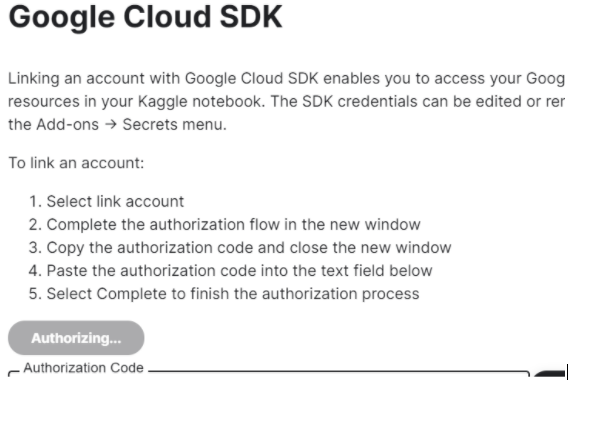
2. Login to your GCS account
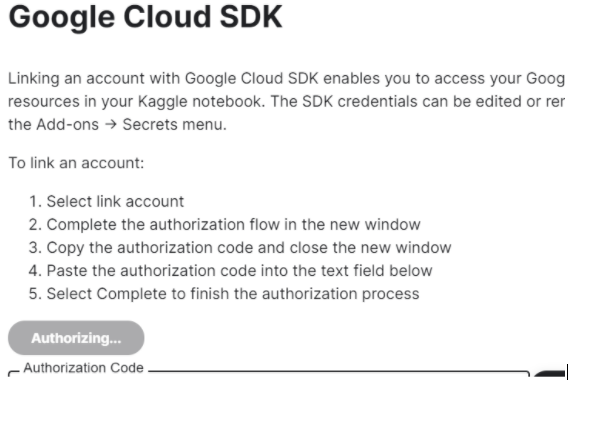
3. You will then be provided with the code snippet below


In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

You can now add a TPU by setting the accelerator to TPU v#-#
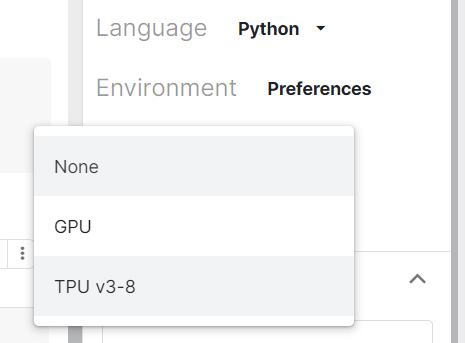

Run the code below to see ther tensorflow version as well as if the TPU is infact running

In [ ]:
print("Tensorflow version " + tf.__version__)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

We created tfrecords for all of the training image files. These records can be accessed by referring to the global storage path

In [ ]:
filenames = tf.io.gfile.glob("gs://dsi_module_4_mm/*.tfrecords")
filenames

We now split the training data into a training set and validation set. We did not use all the images as we the number of files was quite large and we wanted to first generate a training model and see what the performance is like before loading all the images.

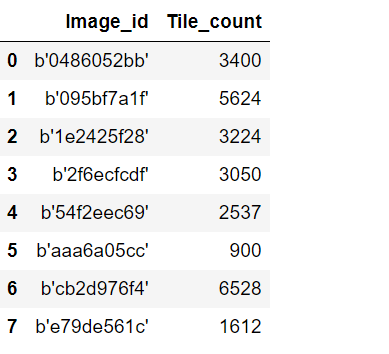

In [ ]:
train_data = np.array(filenames[0:6])
validation_data = np.array(filenames[6:9])
train_data

In [ ]:
validation_data

We now need to read in the TF records.

Steps:

1. Create a dictionary mapping the features of the messages in the TFrecord to a label and specifying the data type
2. Creat a function to decode the messages into images and masks
3. Uncompress the TFrecord and pass it to the decode function 

In [ ]:
image_feature_description = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'mask': tf.io.FixedLenFeature([], tf.string),
      'tile_No': tf.io.FixedLenFeature([], tf.int64),
      'image_id': tf.io.FixedLenFeature([], tf.string),
      'start_row_pixel': tf.io.FixedLenFeature([], tf.int64),
      'start_col_pixel': tf.io.FixedLenFeature([], tf.int64),
      'image_distribution0': tf.io.FixedLenFeature([], tf.string),
      'image_distribution1': tf.io.FixedLenFeature([], tf.string)
      
  }

def _parse_image_function2(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    image_id = single_example['image_id']
    start_row_pixel = single_example['start_row_pixel']
    start_col_pixel = single_example['start_col_pixel']
    
    num_channels = 3
    tile_size = 512
        
    
    image =  tf.io.decode_raw(single_example['image'],out_type='uint8')
   
    #img_array = tf.reshape( image, ( 1, tile_size, tile_size, num_channels))
    img_array = tf.reshape( image, (  tile_size, tile_size, num_channels))
    
    img_array = tf.cast(img_array, tf.float32) / 255.0
   
    mask =  tf.io.decode_raw(single_example['mask'],out_type='bool')
    
    mask = tf.reshape(mask, (tile_size,tile_size))
    
    mask = tf.cast(mask,tf.float32)
    
    image_distribution0 = tf.io.decode_raw(single_example['image_distribution0'], out_type = 'int64')
    image_distribution1 = tf.io.decode_raw(single_example['image_distribution1'], out_type = 'int64')
    
    image_distribution = (image_distribution0, image_distribution1)
    
    mtd = dict()
    mtd['img_index'] = single_example['image_id']
    mtd['tile_id'] = single_example['tile_No']
    mtd['start_col_pixel'] = single_example['start_col_pixel']
    mtd['start_row_pixel'] = single_example['start_row_pixel']
    struct = {
        'img_array': img_array,
        'mask': mask,
        'mtd': mtd,
        'image_distribution': image_distribution,
    } 
    return img_array, mask

In [ ]:
### A second version of the function that manipulates the image dimensions
def _parse_image_function2(example_proto):
    # Parse the input tf.Example protocol. The image_feature_description dictionary must be loaded!
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    #the keys ultimtaley refer to the image_feature_description dictionary
    image_id = single_example['image_id']
    start_row_pixel = single_example['start_row_pixel']
    start_col_pixel = single_example['start_col_pixel']

    num_channels = 3
    tile_size = 512

    image = tf.io.decode_raw(single_example['image'], out_type='uint8')

    img_array = tf.reshape(image, (tile_size, tile_size, num_channels))
    img_array = img_array[None,:,:,:] #needs to be 4-dimensional for the model
    img_array = tf.cast(img_array, tf.float32) / 255.0

    mask = tf.io.decode_raw(single_example['mask'], out_type='bool')
    mask = tf.reshape(mask, (tile_size, tile_size))
    mask = tf.cast(mask, tf.float32) #the model cannot take in bool, so must cast to float

    image_distribution0 = tf.io.decode_raw(single_example['image_distribution0'], out_type='int64')
    image_distribution1 = tf.io.decode_raw(single_example['image_distribution1'], out_type='int64')

    image_distribution = (image_distribution0, image_distribution1)

    mtd = dict()
    mtd['img_index'] = single_example['image_id']
    mtd['tile_id'] = single_example['tile_No']
    mtd['start_col_pixel'] = single_example['start_col_pixel']
    mtd['start_row_pixel'] = single_example['start_row_pixel']
    struct = {
        'img_array': img_array,
        'mask': mask,
        'mtd': mtd,s
        'image_distribution': image_distribution,
    }
    return img_array, mask #, image_distribution0

Reading the TF record:

In [ ]:
def read_tf_dataset2(storage_file_path):
    encoded_image_dataset = tf.data.TFRecordDataset(storage_file_path, compression_type="GZIP")
    parsed_image_dataset = encoded_image_dataset.map(_parse_image_function2)
    return parsed_image_dataset

We now have a function that reads a TFrecord and can be used to generate images and masks that can be passed to a CNN

## U-Net Model

The UNet architecture was proposed in 2015. It was based off a similar architecture called FCN, but it has no dense layer.

The U-Net architecture uses a contracting path and an expansive path (encoder-decoder), which thus give the U-shape. The contracting path is a typical convolutional network with repeated application of convolutions with ReLU and max pooling activations (downsampling operations). The contracting pathways reduce the spatial information while increasing feature information, thus the resolution of the output is increased (at each step the number of features is doubled). The expansive pathway combines the feature and spatial information through a sequence of up-convolutions (down sampling that halves the number of feature channels) and concatenations with the high-resolution features from the contracting pathway ([see more](https://www.kaggle.com/prvnkmr/unet-architecture-breakdown)).   
The basic architecture is:  ![UNet](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

To summarize the architecture:
1. 23 Convolution operations
2. Downsampling operations (Conv(3x3)-->Relu-->Conv(3x3)-->Relu-->MaxPooling
3. Upsampling operations (Upsampling-->Conv(2x2)-->Concatenation-->Conv(3x3)-->Relu-->Conv(3x3)--Relu)
4. Last Level (Conv(1x1)-->2D softmax function which is the sigmoid function)
5. The authors of the paper recommended initailising the kernal weights to have a Gaussian Normal Distribution due to the repeated Convultions and Pooling layers
6. No padding in the layers



In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

We now define the model within a with strategy.scope(): block to ensure the TPU is used. The model designed is very similar to the one in the [paper](https://arxiv.org/pdf/1505.04597.pdf). The differences being that a few normalisation layers were added to the downsampling block and we used strides of 1 for the convolution layers and different size input images.

In [ ]:
with strategy.scope():
    def unet_model(OUTPUT_CHANNELS=1, tile_size=512, strides=1):
        initializer = 'he_normal'
        #keras.initializers.HeNormal()

        inputs = layers.Input(shape=[tile_size, tile_size, 3])

        ###LEVEL1
        d_conv1 = layers.Conv2D(filters=64, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(inputs)
        norm1 = layers.BatchNormalization()(d_conv1)                         
        d_conv2 = layers.Conv2D(filters=64, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(norm1)                             
        d_pool1 = layers.MaxPool2D(pool_size=2, strides=2, padding ='same')(d_conv2)
        ###LEVEL2
        d_conv3 = layers.Conv2D(filters=128, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(d_pool1)
        norm2 = layers.BatchNormalization()(d_conv3)                             
        d_conv4 = layers.Conv2D(filters=128, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(norm2)
        d_pool2 = layers.MaxPool2D(pool_size=2, strides=2, padding='same')(d_conv4)
        ##LEVEL3
        d_conv5 = layers.Conv2D(filters=256, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(d_pool2)
        d_conv6 = layers.Conv2D(filters=256, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(d_conv5)
        d_pool3 = layers.MaxPool2D(pool_size=2, strides=2, padding='same')(d_conv6)
        ###LEVEL4
        d_conv7 = layers.Conv2D(filters=512, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(d_pool3)
        d_conv8 = layers.Conv2D(filters=512, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(d_conv7)
        d_pool4 = layers.MaxPool2D(pool_size=2, strides=2, padding='same')(d_conv8)
        ###LEVEL5
        d_conv9 = layers.Conv2D(filters=1024, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(d_pool4)
        d_conv10 = layers.Conv2D(filters=1024, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(d_conv9)    

        ###Upsampling
        ###LEVEL1
        u_sample1 = layers.UpSampling2D(size=2)(d_conv10)
        u_conv11 = layers.Conv2D(filters=512, kernel_size=2, strides=strides, padding='same',
                                 kernel_initializer=initializer)(u_sample1)
        u_copy1 = layers.Concatenate(axis = 3)([d_conv8, u_conv11])

        u_conv12 = layers.Conv2D(filters=512, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(u_copy1)
        u_conv13 = layers.Conv2D(filters=512, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(u_conv12)
        ###Level2

        u_sample2 = layers.UpSampling2D(size=2)(u_conv13)
        u_conv14 = layers.Conv2D(filters=256, kernel_size=2, strides=strides, padding='same',
                                 kernel_initializer=initializer)(u_sample2)
        u_copy2 = layers.Concatenate(axis = 3)([d_conv6, u_conv14])
        u_conv15 = layers.Conv2D(filters=256, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(u_copy2)
        u_conv16 = layers.Conv2D(filters=256, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(u_conv15)


        ###Level3

        u_sample3 = layers.UpSampling2D(size=2)(u_conv16)
        u_conv17 = layers.Conv2D(filters=128, kernel_size=2, strides=strides, padding='same',
                                 kernel_initializer=initializer)(u_sample3)
        u_copy3 = layers.Concatenate(axis = 3)([d_conv4, u_conv17])
        u_conv18 = layers.Conv2D(filters=128, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(u_copy3)

        u_conv19 = layers.Conv2D(filters=128, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(u_conv18)

        ###Level4

        u_sample4 = layers.UpSampling2D(size=2)(u_conv19)
        u_conv20 = layers.Conv2D(filters=64, kernel_size=2, strides=strides, padding='same',
                                 kernel_initializer=initializer)(u_sample4)
        u_copy4 = layers.Concatenate(axis = 3)([d_conv2, u_conv20])
        u_conv21 = layers.Conv2D(filters=64, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(u_copy4)
        u_conv22 = layers.Conv2D(filters=64, kernel_size=3, strides=strides, padding='same',
                                 kernel_initializer=initializer, activation ='relu')(u_conv21)
        ###Last Level
        u_conv23 = layers.Conv2D(filters =1, kernel_size = OUTPUT_CHANNELS, activation='sigmoid')(u_conv22)

        return keras.Model(inputs=inputs, outputs=u_conv23)

We now compile the model

In [ ]:
with strategy.scope():   
    model = unet_model()
    model.summary()
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=dice_loss,
              metrics=[dice_coeff])

We then fit the model to the data set using a batch size of 128 and 30 epochs. 

In [ ]:
with strategy.scope():
    ACCELERATOR_TYPE = 'TPU'
    if ACCELERATOR_TYPE == 'TPU':
        batch_size = 128
        train_dataset = read_tf_dataset2(train_data) 
        train_dataset = train_dataset.batch(batch_size, drop_remainder=True).cache().prefetch(2)
        validation_dataset = read_tf_dataset2(validation_data)
        validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True).prefetch(2)
        steps_per_epoch = 100
        checkpointer = ModelCheckpoint('/kaggle/working/unet-tpu.h5', verbose=1)
        history = model.fit(train_dataset,batch_size=batch_size,validation_data=validation_dataset, epochs=5,callbacks=[checkpointer])
        model.save_weights("/kaggle/working/hubmap-tpu-unetf.h5")
        model.save("/kaggle/working/hubmap-tpu-unet_model.h5")
    

We first ran the training model without a validation dataset, to get an idea of the training times. The below information summarises this:

Epoch 1/30
    119/Unknown - 167s 1s/step - dice_coeff: 0.2725 - loss: 0.7275
Epoch 00001: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 169s 1s/step - dice_coeff: 0.2725 - loss: 0.7275
Epoch 2/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00002: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 886ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 3/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00003: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 4/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00004: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 5/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00005: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 6/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00006: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 7/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00007: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 8/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00008: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 9/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00009: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 106s 888ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 10/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00010: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 106s 887ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 11/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00011: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 12/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00012: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 13/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00013: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 14/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00014: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 15/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00015: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 16/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00016: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 17/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00017: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 18/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00018: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 19/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00019: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 20/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00020: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 21/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00021: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 22/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00022: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 23/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00023: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 24/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00024: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 25/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00025: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 26/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00026: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 27/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00027: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 105s 885ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 28/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00028: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 106s 888ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 29/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00029: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 106s 887ms/step - dice_coeff: 0.2920 - loss: 0.7080
Epoch 30/30
119/119 [==============================] - ETA: 0s - dice_coeff: 0.2920 - loss: 0.7080
Epoch 00030: saving model to /kaggle/working/unet-tpu.h5
119/119 [==============================] - 106s 888ms/step - dice_coeff: 0.2920 - loss: 0.7080


In [ ]:
history

This plots  a graph comparing training to validation

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['dice_coeff', 'val_dice_coeff']].plot();

In [ ]:
history_frame

In [ ]:
history_frame.to_csv('model_performance')

## Acknowlegements
This workflow is based on the below sources, mainly by reading other Kaggle Kernals, in particular the Notebooks of the Hacking the Kidney coach Marcos Novaes' notebook series.
- https://www.kaggle.com/marcosnovaes/hubmap-3-unet-models-with-keras-cpu-gpu/   
- https://www.kaggle.com/marcosnovaes/hubmap-unet-keras-model-fit-with-tpu